In [1]:
%matplotlib inline

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

## data loaded
Train set:      Cancer: Non cancer:
Validation set: Cancer: Non cancer:
Batch size=3

In [3]:
data_transforms = {'train':transforms.ToTensor(),'val': transforms.ToTensor()}


In [4]:
data_dir = 'Cancer_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=3,shuffle=True, num_workers=5) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

## visualize a batch of data

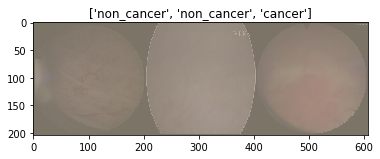

In [5]:
#in case of test error,modify here too!
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


# Get a batch of validation data
#inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
#out1 = torchvision.utils.make_grid(inputs1)

#imshow(out1, title=[class_names[x] for x in classes1])

## General function to train a model

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Generic function to display predictions for a few images

In [11]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        #print('hello')
        #print(type(inputs))
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

# Finetuning the convnet

## Load a pretrained model and reset final fully connected layer.


In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1896 Acc: 0.7868
val Loss: 0.0277 Acc: 0.9632

Epoch 1/24
----------
train Loss: 0.1888 Acc: 0.8033
val Loss: 0.0276 Acc: 0.9706

Epoch 2/24
----------
train Loss: 0.1722 Acc: 0.8188
val Loss: 0.1492 Acc: 0.7794

Epoch 3/24
----------
train Loss: 0.1180 Acc: 0.8702
val Loss: 0.0325 Acc: 0.9706

Epoch 4/24
----------
train Loss: 0.1194 Acc: 0.8808
val Loss: 0.0282 Acc: 0.9706

Epoch 5/24
----------
train Loss: 0.0726 Acc: 0.9167
val Loss: 0.0101 Acc: 0.9926

Epoch 6/24
----------
train Loss: 0.0492 Acc: 0.9438
val Loss: 0.0159 Acc: 0.9853

Epoch 7/24
----------
train Loss: 0.0213 Acc: 0.9767
val Loss: 0.0128 Acc: 0.9853

Epoch 8/24
----------
train Loss: 0.0137 Acc: 0.9893
val Loss: 0.0165 Acc: 0.9853

Epoch 9/24
----------
train Loss: 0.0124 Acc: 0.9922
val Loss: 0.0106 Acc: 0.9853

Epoch 10/24
----------
train Loss: 0.0102 Acc: 0.9932
val Loss: 0.0105 Acc: 0.9853

Epoch 11/24
----------
train Loss: 0.0099 Acc: 0.9961
val Loss: 0.0072 Acc: 0.9853

Ep

hello
<class 'torch.FloatTensor'>


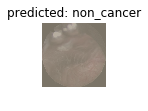

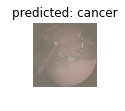

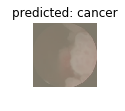

hello
<class 'torch.FloatTensor'>


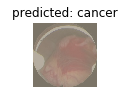

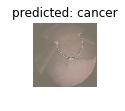

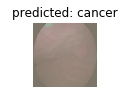

In [12]:
visualize_model(model_ft)

In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1962 Acc: 0.7297
val Loss: 0.0747 Acc: 0.8897

Epoch 1/24
----------
train Loss: 0.2250 Acc: 0.7432
val Loss: 0.0839 Acc: 0.8897

Epoch 2/24
----------
train Loss: 0.1940 Acc: 0.7771
val Loss: 0.1056 Acc: 0.8971

Epoch 3/24
----------
train Loss: 0.1608 Acc: 0.8227
val Loss: 0.1252 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.1654 Acc: 0.8314
val Loss: 0.0791 Acc: 0.8971

Epoch 5/24
----------
train Loss: 0.1882 Acc: 0.7878
val Loss: 0.0839 Acc: 0.8971

Epoch 6/24
----------
train Loss: 0.1393 Acc: 0.8401
val Loss: 0.0941 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.1209 Acc: 0.8382
val Loss: 0.0796 Acc: 0.8750

Epoch 8/24
----------
train Loss: 0.1303 Acc: 0.8372
val Loss: 0.0893 Acc: 0.8750

Epoch 9/24
----------
train Loss: 0.1183 Acc: 0.8450
val Loss: 0.0716 Acc: 0.9118

Epoch 10/24
----------
train Loss: 0.1095 Acc: 0.8624
val Loss: 0.0699 Acc: 0.9191

Epoch 11/24
----------
train Loss: 0.1083 Acc: 0.8634
val Loss: 0.0869 Acc: 0.8750

Ep

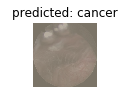

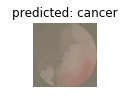

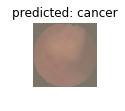

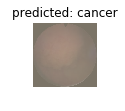

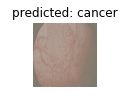

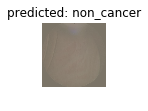

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()